# III. Third Task  👨‍💻: Feature Engineering
The goal of feature engineering is simply to make your data better suited to the problem at hand. 
Steps followed in this task:

**1.Feature Reduction with Principal Component Analysis - PCA  
2.Feature Selection Techniques:**
 - Correlation Coefficient
 - Mutual Information Selection
 - Chi square
 
**3. Some additionnal Selection Techniques**
- Variance Threshold
- Fisher Score

# Librairies && Data 📚

In [1]:
# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2, VarianceThreshold

#!pip install skfeature-chappers
from skfeature.function.similarity_based import fisher_score

# settings & warning handling
import warnings
pd.options.display.max_columns
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

In [2]:
# read in csv file as a DataFrame
data = pd.read_csv("Prepared_Dataset.csv", index_col=0)
data.drop(["Parsed_FirstPaymentDate", "Parsed_MaturityDate"], axis=1, inplace=True)

# Again Quick Look at the Data Structure 👀

In [3]:
# explore the first 5 rows
data.head()

,CreditScore,FirstTimeHomebuyer,MSA,MIP,Units,Occupancy,OCLTV,DTI,OrigUPB,LTV,...,FirstPayment_Year,FirstPayment_Month,Maturity_Year,Maturity_Month,LTV_range,Credit_range,YearsInRepayment,Repay_range,IsFirstTimeHomebuyer,Duration
0,711.841009,0,16974,25,1,O,89,27.0,117000,89.0,...,1999,2,2029,1,High,Good,4.333333,2,No,30
1,711.841009,0,19740,0,1,O,73,17.0,109000,73.0,...,1999,2,2029,1,High,Good,12.000000,4,No,30
2,711.841009,0,29940,0,1,O,75,16.0,88000,75.0,...,1999,2,2029,1,High,Good,5.583333,2,No,30
3,711.841009,0,31084,0,1,O,76,14.0,160000,76.0,...,1999,2,2029,1,High,Good,2.916667,1,No,30
4,711.841009,0,35644,0,1,O,78,18.0,109000,78.0,...,1999,2,2029,1,High,Good,4.500000,2,No,30


In [4]:
# size of the dataset
data.shape

(291449, 33)

In [5]:
# checking the columns names
data.columns

Index(['CreditScore', 'FirstTimeHomebuyer', 'MSA', 'MIP', 'Units', 'Occupancy',
       'OCLTV', 'DTI', 'OrigUPB', 'LTV', 'OrigInterestRate', 'Channel', 'PPM',
       'PropertyState', 'PropertyType', 'LoanPurpose', 'OrigLoanTerm',
       'NumBorrowers', 'SellerName', 'ServicerName', 'EverDelinquent',
       'MonthsDelinquent', 'MonthsInRepayment', 'FirstPayment_Year',
       'FirstPayment_Month', 'Maturity_Year', 'Maturity_Month', 'LTV_range',
       'Credit_range', 'YearsInRepayment', 'Repay_range',
       'IsFirstTimeHomebuyer', 'Duration'],
      dtype='object')

In [6]:
# See changes in columns after the first and second tasks
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291449 entries, 0 to 291450
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   CreditScore           291449 non-null  float64
 1   FirstTimeHomebuyer    291449 non-null  int64  
 2   MSA                   291449 non-null  int64  
 3   MIP                   291449 non-null  int64  
 4   Units                 291449 non-null  int64  
 5   Occupancy             291449 non-null  object 
 6   OCLTV                 291449 non-null  int64  
 7   DTI                   291449 non-null  float64
 8   OrigUPB               291449 non-null  int64  
 9   LTV                   291449 non-null  float64
 10  OrigInterestRate      291449 non-null  float64
 11  Channel               291449 non-null  object 
 12  PPM                   291449 non-null  int64  
 13  PropertyState         291449 non-null  object 
 14  PropertyType          291449 non-null  object 
 15  

In [7]:
data.columns

Index(['CreditScore', 'FirstTimeHomebuyer', 'MSA', 'MIP', 'Units', 'Occupancy',
       'OCLTV', 'DTI', 'OrigUPB', 'LTV', 'OrigInterestRate', 'Channel', 'PPM',
       'PropertyState', 'PropertyType', 'LoanPurpose', 'OrigLoanTerm',
       'NumBorrowers', 'SellerName', 'ServicerName', 'EverDelinquent',
       'MonthsDelinquent', 'MonthsInRepayment', 'FirstPayment_Year',
       'FirstPayment_Month', 'Maturity_Year', 'Maturity_Month', 'LTV_range',
       'Credit_range', 'YearsInRepayment', 'Repay_range',
       'IsFirstTimeHomebuyer', 'Duration'],
      dtype='object')

In [8]:
# List of numerical columns, binary and categorical columns

target   = 'EverDelinquent'

binary_cols = [ 'PPM', 'NumBorrowers', #'IsFirstTimeHomebuyer'
              ]

numeric_cols = data.select_dtypes(include=['float', 'int']).columns.tolist()
numeric_cols = [i for i in numeric_cols if i not in binary_cols]
numeric_cols.remove(target)
numeric_cols.remove('MonthsDelinquent')

categ_cols  = data.select_dtypes(include=['object']).columns.tolist()


# checking that all columns have been added to a category
len(numeric_cols)+len(binary_cols)+len(categ_cols)

31

In [9]:
# firstly let's separate features from target
y = data['EverDelinquent']
X = data.drop('EverDelinquent', axis=1)

# 1. Feature Reduction with Principal Component Analysis - PCA

In [10]:
# Let's first combine categorical and binary data into a single DataFrame
categorical_data = pd.get_dummies(X[categ_cols])
binary_data      = X[binary_cols]

combined_data    = pd.concat([categorical_data, binary_data], axis=1)

In [11]:
# Standardize numerical data
scaler = StandardScaler()
numeric_data = scaler.fit_transform(X[numeric_cols])

In [12]:
# combining numeric, categoric and binary data
X_combined = np.concatenate((numeric_data, combined_data), axis=1)

# now we'll perform PCA on the combined data
pca = PCA()
X_pca = pca.fit_transform(X_combined)


# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74
0,-0.596866,-1.159089,0.620106,-3.185871,0.230846,-0.545542,0.366345,-0.892142,0.856404,-0.033930,...,-1.783167e-14,2.524530e-14,1.815008e-15,8.151774e-15,2.069150e-14,1.429866e-14,-2.850918e-14,-1.208951e-14,-7.591351e-15,-6.195243e-16
1,3.513477,-1.111913,1.471395,-2.753451,0.294442,-0.340660,0.250152,-0.889609,0.595651,-0.017853,...,4.181881e-16,-1.011286e-16,-1.988261e-17,-2.494320e-17,7.297730e-17,2.063195e-17,-3.406282e-17,1.660143e-18,2.523493e-18,7.671116e-19
2,1.286039,-0.572198,-0.534672,-2.818151,0.061962,-1.021150,0.382216,-0.296283,-0.019296,0.849431,...,-3.179672e-15,1.206944e-15,-8.504779e-16,-2.258868e-15,-1.173645e-15,-7.740352e-17,-1.542622e-16,1.897312e-16,-8.522658e-17,-1.817801e-18
3,0.149214,-0.243546,-1.502252,-3.009152,0.108770,-0.412966,0.036917,-0.101497,0.066118,0.871811,...,-4.597324e-15,1.754157e-15,-7.508822e-16,2.546864e-15,2.131249e-14,8.747116e-15,1.206300e-14,1.681345e-15,-1.033033e-16,-4.738060e-17
4,0.761771,-0.520775,-0.583669,-2.670708,-0.098656,-1.031454,0.407764,0.207223,-0.264427,1.201851,...,-2.712676e-16,2.984119e-16,5.521738e-16,-7.657637e-16,-2.901700e-15,-1.158569e-15,-1.207867e-16,4.083659e-16,6.286244e-16,-1.239135e-16


In [13]:
# the PCA instance contains the loadings in its components_ attribute, We'll wrap the loadings up in a dataframe
loadings = pd.DataFrame(
                        pca.components_.T,                                    # transpose the matrix of loadings
                        columns=component_names,                              # so the columns are the principal components
                        index= numeric_cols + combined_data.columns.tolist()  # and the rows are the original features
                       )

In [14]:
loadings.iloc[:15, :15]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
CreditScore,0.137467,0.072322,-0.157846,-0.003101,0.565715,0.164692,-0.227108,0.018322,0.210780,0.208378,0.525521,0.141069,-0.028192,-0.051951,0.001822
FirstTimeHomebuyer,-0.149220,-0.080466,0.185503,0.035821,0.505929,-0.049992,0.077016,0.444265,-0.226808,-0.391856,-0.224056,0.104600,0.056158,-0.127502,0.027643
MSA,0.013482,0.019347,-0.057803,0.005052,-0.140055,0.217219,-0.218323,0.486036,-0.554468,0.512582,0.021762,-0.215766,-0.038692,-0.031344,0.033583
MIP,-0.327773,-0.139423,0.302790,-0.068334,0.062880,-0.030201,-0.009181,-0.026750,0.027013,0.139729,0.097627,-0.061448,0.066958,0.742235,0.275971
Units,0.029535,0.004318,-0.016722,0.034105,-0.127995,-0.030121,0.064198,0.600232,0.709705,0.077271,-0.089263,-0.301277,0.037815,0.001603,0.005409
OCLTV,-0.377071,-0.159603,0.343179,-0.088041,-0.013336,0.075638,-0.077898,-0.097946,0.096551,0.165486,0.068391,-0.031646,-0.013375,-0.308140,-0.101083
DTI,-0.098054,-0.028593,0.035834,0.043771,-0.371529,0.229232,0.051800,0.190272,-0.111397,-0.535120,0.659508,-0.078464,-0.047443,0.010747,-0.025339
OrigUPB,-0.138641,0.025295,-0.105053,-0.082841,-0.160968,0.574463,-0.290052,0.079685,0.178629,-0.112623,-0.296511,0.541561,-0.187776,0.110918,0.027034
LTV,-0.377288,-0.159618,0.343239,-0.088146,-0.013315,0.075034,-0.077743,-0.097621,0.096219,0.165983,0.068392,-0.031910,-0.011959,-0.306504,-0.100334
OrigInterestRate,-0.130354,0.007130,0.017347,0.239875,-0.194504,-0.447256,0.244517,0.244600,-0.011334,0.256262,0.200324,0.662475,-0.070298,-0.009886,-0.065062


In [15]:
print(pca.explained_variance_ratio_ * 100)

[1.41883922e+01 1.23457011e+01 1.14014931e+01 7.94454703e+00
 5.28536651e+00 5.02702070e+00 4.74454316e+00 4.43764018e+00
 4.26032745e+00 4.09028166e+00 3.69070949e+00 2.98379262e+00
 2.42304354e+00 1.82037158e+00 1.47513594e+00 1.43351673e+00
 1.34809082e+00 1.12286727e+00 8.90818757e-01 8.62469984e-01
 8.00742606e-01 7.34701379e-01 7.02564897e-01 6.72166443e-01
 5.73635732e-01 5.55253010e-01 5.11780300e-01 4.28872643e-01
 3.47409093e-01 3.11891917e-01 2.90661163e-01 2.65948151e-01
 2.57178692e-01 2.22632965e-01 1.93539596e-01 1.56926380e-01
 1.48640947e-01 1.07698606e-01 1.01301493e-01 9.66210926e-02
 9.21678915e-02 8.64335927e-02 7.31854286e-02 6.50077034e-02
 6.31351229e-02 5.70350293e-02 5.02888343e-02 4.73517916e-02
 4.39807445e-02 4.16282262e-02 3.46640580e-02 2.98700489e-02
 2.55132035e-02 1.39597822e-02 9.03781051e-03 3.13612372e-03
 2.79923967e-03 1.99369029e-03 1.35732735e-03 1.15734741e-03
 3.89280984e-27 1.93137585e-29 1.81068460e-29 1.20075044e-29
 7.31358347e-30 5.492483

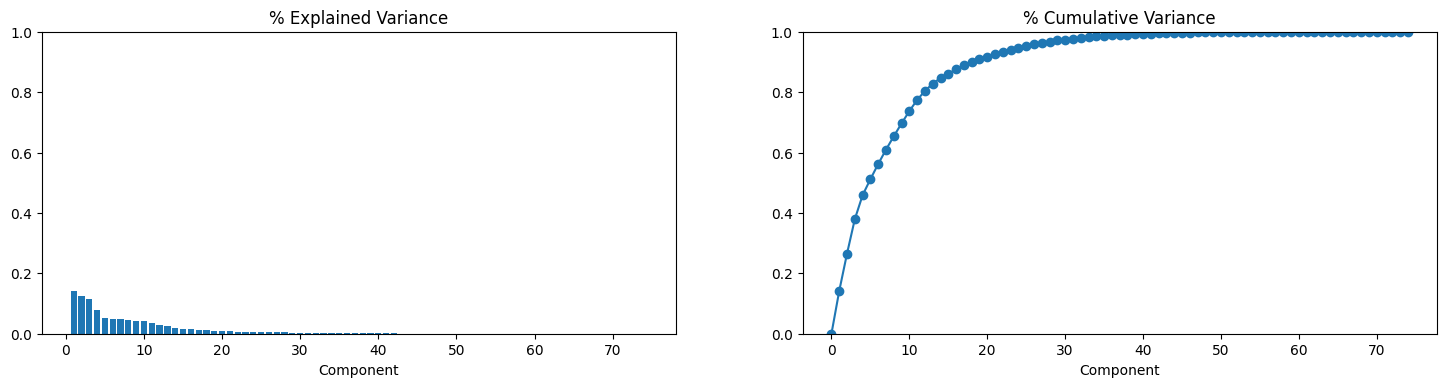

In [16]:
def plot_variance(pca, width=16, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=18, dpi=100)
    return axs

# Look at explained variance
plot_variance(pca);

In [17]:
# Choose the number of components based on explained variance: a suitable threshold (e.g., 95% explained variance)
num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.80) + 1
num_components

12

In [18]:
# Perform PCA again with the chosen number of components
pca_final = PCA(n_components=num_components)

X_pca_final = pca_final.fit_transform(X_combined)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca_final.shape[1])]
X_pca_final = pd.DataFrame(X_pca_final, columns=component_names)

X_pca_final.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-0.596866,-1.159094,0.620103,-3.185867,0.230904,-0.545424,0.366163,-0.892277,0.856160,-0.033818,0.137964,0.250760
1,3.513477,-1.111908,1.471393,-2.753463,0.294351,-0.340815,0.250247,-0.889424,0.595981,-0.017892,-0.900447,0.063736
2,1.286039,-0.572203,-0.534676,-2.818148,0.061990,-1.021250,0.381943,-0.296477,-0.019216,0.849370,-0.663906,0.267964
3,0.149215,-0.243540,-1.502247,-3.009170,0.108778,-0.412798,0.037334,-0.101255,0.065999,0.871997,-1.282412,0.593559
4,0.761771,-0.520768,-0.583665,-2.670722,-0.098763,-1.031651,0.407901,0.207318,-0.263957,1.201420,-0.575556,0.520036


In [19]:
X_pca_final.to_csv("X_pca_final.csv")
X_pca_final.shape

(291449, 12)

Finally we have only 13 features in the PCA dataset at the cost of 20% variance loss.
So we can use these components or features for modeling or simply add the first two or three columns to the original data for modeling.

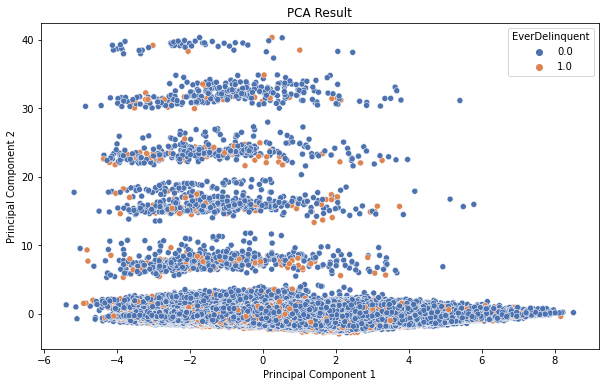

In [20]:
# Visualize the PCA result by the target
pca_cols_target = pd.concat([X_pca_final, data['EverDelinquent']], axis=1)
plt.figure(figsize=(10, 6))
sns.scatterplot(data = pca_cols_target, x='PC1', y='PC2', hue='EverDelinquent', palette="deep")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.show()

# 2. Feature Selection Techniques
The main goal of feature selection techniques we're going to use is to find the best set of features that allows us to build optimized models for our problem statement.

In [21]:
# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes
discrete_features = X.dtypes == int

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291449 entries, 0 to 291450
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   CreditScore           291449 non-null  float64
 1   FirstTimeHomebuyer    291449 non-null  int64  
 2   MSA                   291449 non-null  int64  
 3   MIP                   291449 non-null  int64  
 4   Units                 291449 non-null  int64  
 5   Occupancy             291449 non-null  int64  
 6   OCLTV                 291449 non-null  int64  
 7   DTI                   291449 non-null  float64
 8   OrigUPB               291449 non-null  int64  
 9   LTV                   291449 non-null  float64
 10  OrigInterestRate      291449 non-null  float64
 11  Channel               291449 non-null  int64  
 12  PPM                   291449 non-null  int64  
 13  PropertyState         291449 non-null  int64  
 14  PropertyType          291449 non-null  int64  
 15  

## Correlation Coefficient

Correlation is a measure of the linear relationship between 2 or more variables. Through correlation, we can predict one variable from the other. The logic behind using correlation for feature selection is that good variables correlate highly with the target.

In [23]:
corr = data.corr()
print("Feature correlations to the target by descending order:\n\n", corr['EverDelinquent'].sort_values(ascending=False))

Feature correlations to the target by descending order:

 EverDelinquent        1.000000
MonthsDelinquent      0.420035
YearsInRepayment      0.232494
MonthsInRepayment     0.232494
Repay_range           0.220811
LTV                   0.065741
OCLTV                 0.065519
OrigInterestRate      0.060420
MIP                   0.059984
DTI                   0.050942
OrigLoanTerm          0.010348
Units                 0.010190
Duration              0.009805
FirstTimeHomebuyer    0.002111
Maturity_Year         0.002068
Maturity_Month       -0.003499
FirstPayment_Month   -0.003908
FirstPayment_Year    -0.011695
MSA                  -0.011770
PPM                  -0.012167
OrigUPB              -0.067616
NumBorrowers         -0.071771
CreditScore          -0.266119
Name: EverDelinquent, dtype: float64


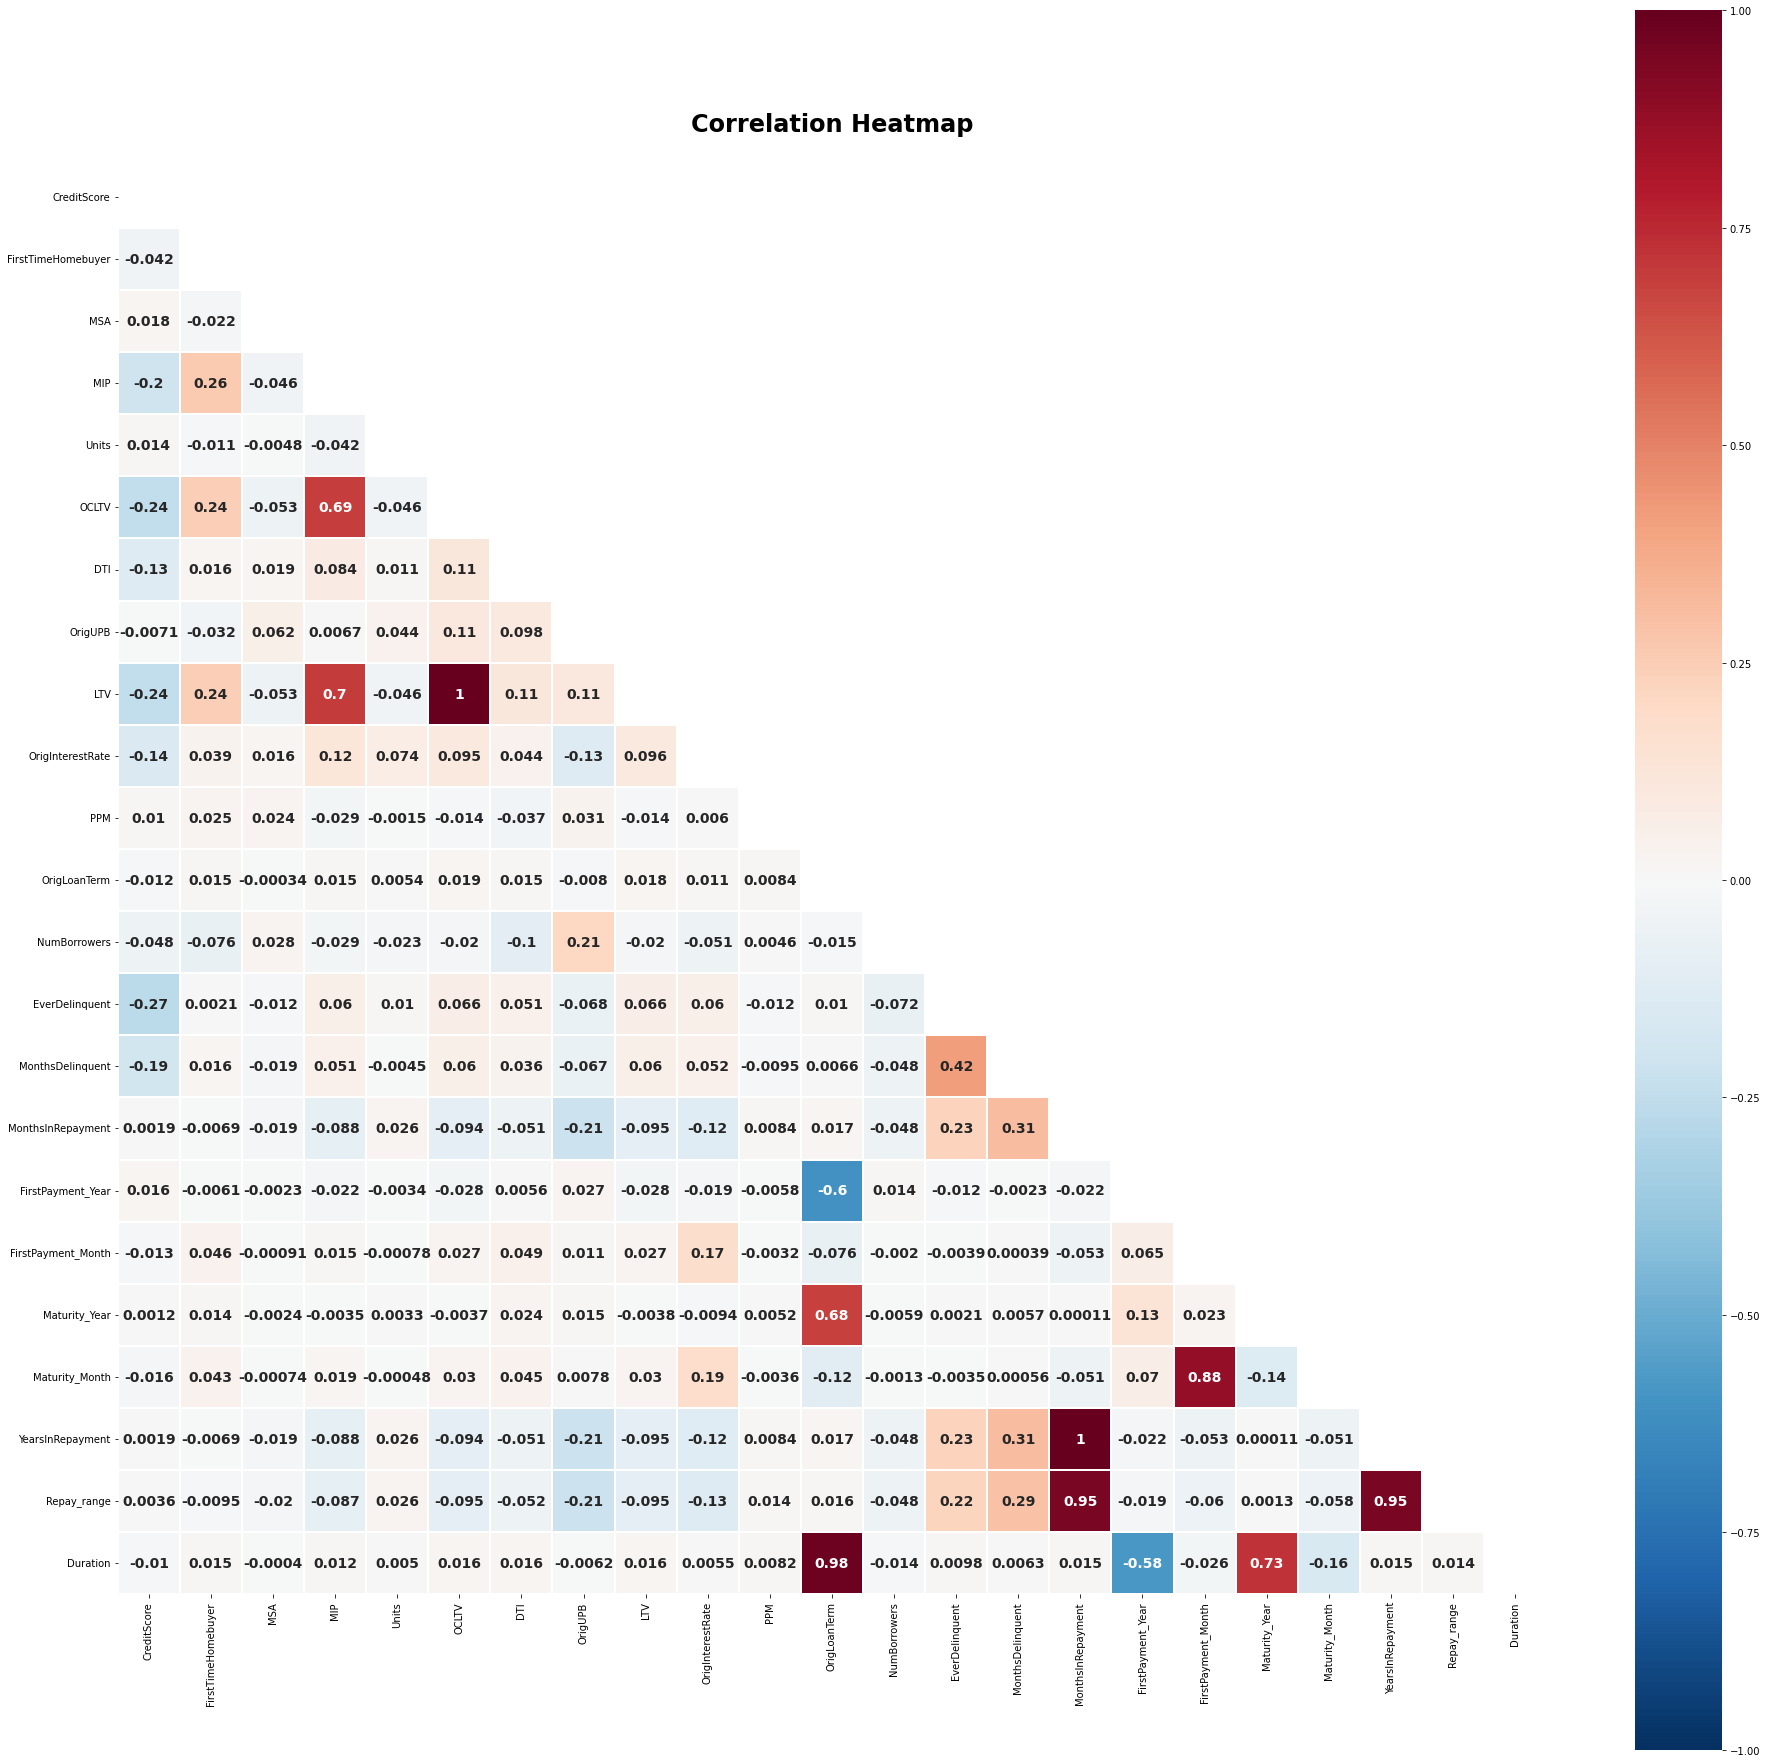

In [24]:
# let's understand correlations to the target by a visual way using heatmap
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(32, 32))

    # Set the title and font properties
    plt.title(f'{title} Heatmap', fontweight='bold', y=1.02, size=24)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(data, title='Correlation')

We need to set an absolute value, say 0.2, as the threshold for selecting the variables. 

If we find that the predictor variables are correlated, we can drop the variable with a lower correlation coefficient value than the target variable. 

In [25]:
treshold = 0.06
absolute_corr_to_target = abs(corr['EverDelinquent'])
filtered = absolute_corr_to_target[absolute_corr_to_target > treshold].sort_values(ascending=False)

print("These are the columns that are more correlated(linearly) to the target: \n\n", filtered)

These are the columns that are more correlated(linearly) to the target: 

 EverDelinquent       1.000000
MonthsDelinquent     0.420035
CreditScore          0.266119
YearsInRepayment     0.232494
MonthsInRepayment    0.232494
Repay_range          0.220811
NumBorrowers         0.071771
OrigUPB              0.067616
LTV                  0.065741
OCLTV                0.065519
OrigInterestRate     0.060420
Name: EverDelinquent, dtype: float64


In [26]:
filtered.index.tolist()

['EverDelinquent',
 'MonthsDelinquent',
 'CreditScore',
 'YearsInRepayment',
 'MonthsInRepayment',
 'Repay_range',
 'NumBorrowers',
 'OrigUPB',
 'LTV',
 'OCLTV',
 'OrigInterestRate']

In [27]:
most_correlated_features = [
                             'MonthsDelinquent',
                             'CreditScore',
                             'YearsInRepayment',
                             'Repay_range',
                             'NumBorrowers',
                             'OrigUPB',
                             'LTV',
                             'OrigInterestRate']

X_correlated = X[most_correlated_features]
X_correlated.head()

,MonthsDelinquent,CreditScore,YearsInRepayment,Repay_range,NumBorrowers,OrigUPB,LTV,OrigInterestRate
0,0,711.841009,4.333333,2,2,117000,89.0,6.750
1,0,711.841009,12.000000,4,1,109000,73.0,6.500
2,0,711.841009,5.583333,2,2,88000,75.0,6.875
3,0,711.841009,2.916667,1,2,160000,76.0,6.875
4,0,711.841009,4.500000,2,2,109000,78.0,7.125


Looking at the heatmap, we can notice that most of the features are not correlated to each other.  
Only 8 features have strong absolute correlation to the target(greater than 0.06).

## Mutual Information Selection
Information gain or mutual information measures how much information the presence/absence of a feature contributes to making the correct prediction on the target.  
It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

In [28]:
# function to compute the MI scores for our features and wraps them up in a nice dataframe
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores # show features with their MI scores

MonthsDelinquent        0.497776
Units                   0.045924
OrigLoanTerm            0.045196
Credit_range            0.039317
Repay_range             0.037517
CreditScore             0.035768
Duration                0.033837
FirstPayment_Year       0.033341
Maturity_Year           0.032011
NumBorrowers            0.031013
YearsInRepayment        0.030533
MonthsInRepayment       0.029777
FirstPayment_Month      0.014993
Maturity_Month          0.014944
PropertyState           0.011885
LoanPurpose             0.010273
Channel                 0.009353
MIP                     0.008010
SellerName              0.007356
OrigInterestRate        0.007339
OCLTV                   0.007279
LTV                     0.007274
ServicerName            0.006664
MSA                     0.004798
DTI                     0.004042
OrigUPB                 0.003916
PropertyType            0.001943
LTV_range               0.001548
FirstTimeHomebuyer      0.000335
IsFirstTimeHomebuyer    0.000080
Occupancy 

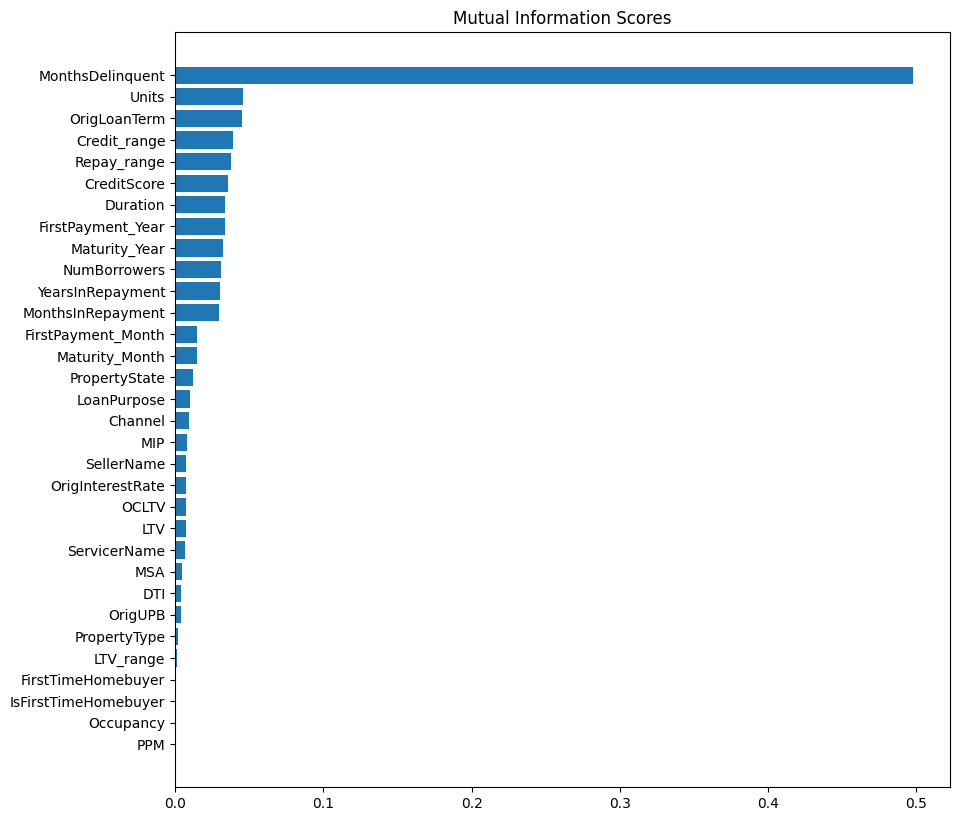

In [29]:
# function to visualize a bar plot to make comparisions easier
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 10))
plot_mi_scores(mi_scores)

Remarks:
Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

- MonthsDelinquent MI score is extremely huge meaning that there is a high dependency between it and the target. This feature can add noise to our models so dropping it could be a good idea.
- The following features after MonthsDelinquent are showing good mi scores so they could be important for models.

In [30]:
best_mi_cols = mi_scores.index.tolist()[:15]
best_mi_cols

['MonthsDelinquent',
 'Units',
 'OrigLoanTerm',
 'Credit_range',
 'Repay_range',
 'CreditScore',
 'Duration',
 'FirstPayment_Year',
 'Maturity_Year',
 'NumBorrowers',
 'YearsInRepayment',
 'MonthsInRepayment',
 'FirstPayment_Month',
 'Maturity_Month',
 'PropertyState']

In [31]:
X_best_mi_scores = X[best_mi_cols]
X_best_mi_scores.to_csv('X_best_mi_scores.csv')
X_best_mi_scores.shape

(291449, 15)

## Chi-square
The Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with the best Chi-square scores(k highest scores).
To apply this method, the following conditions have to be met:
- the variables have to be categorical,
- sampled independently,
- values should have an expected frequency greater than 5.

In [32]:
# convert to categorical by converting to integers
X_cat = X.astype(int)

In [33]:
chi2_features = SelectKBest(chi2, k=15)
X_chi2_best = chi2_features.fit_transform(X_cat, y)

In [34]:
X_chi2_best = pd.DataFrame(X_chi2_best, columns=X_cat.columns.tolist()[:15])

# View results
print('Original number of features:', X_cat.shape[1])
print('Reduced number of features:', X_chi2_best.shape[1])

Original number of features: 32
Reduced number of features: 15


In [35]:
X_chi2_best.columns.tolist()

['CreditScore',
 'FirstTimeHomebuyer',
 'MSA',
 'MIP',
 'Units',
 'Occupancy',
 'OCLTV',
 'DTI',
 'OrigUPB',
 'LTV',
 'OrigInterestRate',
 'Channel',
 'PPM',
 'PropertyState',
 'PropertyType']

In [37]:
X_chi2_best.to_csv("X_chi2_best.csv")
X_chi2_best.shape

(291449, 15)

Thus, we have selected the ten best features from our dataset according to Chi2 test.

# 3. Some additionnal Selection Techniques

## Variance Threshold

Variance threshold from sklearn is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.

In [38]:
# using sklearn variancethreshold to find constant features

sel = VarianceThreshold(threshold=0)
sel.fit(X)        # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [39]:
# get_support is a boolean vector that indicates which features are retained
# if we sum over get_support, we get the number of features that are not constant
sum(sel.get_support())

32

In [40]:
# print the constant features
print(
    len([
        x for x in X.columns
        if x not in X.columns[sel.get_support()]
    ]))

[x for x in X.columns if x not in X.columns[sel.get_support()]]

0


[]

We can see that there are no columns / variables that are constant.  
This means that no variables show the same value, for all the observations of the training set.

## Fisher Score
The algorithm we will use returns the ranks of the variables based on the fisher’s score in descending order. We can then select the variables as per the case.

In [41]:
# computing the scores
#ranks = fisher_score(X, y)

In [42]:
# function for plotting ranks
def plot_ranks(ranks):
    ranks = ranks.sort_values(ascending=True)
    width = np.arange(len(ranks))
    ticks = list(ranks.index)
    plt.barh(width, ranks)
    plt.yticks(width, ticks)
    plt.title("Fisher Score - Ranks")

#plt.figure(dpi=100, figsize=(10, 10))
#plot_ranks(ranks)

In [43]:
X.to_csv('X_full.csv')

In [46]:
best_cols = ['Credit_range', 'Repay_range', 'LTV_range', 'FirstTimeHomebuyer', 'ServicerName', 'PropertyState', 'NumBorrowers',
             'MonthsInRepayment', 'OrigUPB', 'OrigInterestRate', 'Units', 'OrigLoanTerm', 'Duration', 'PropertyState', 'LoanPurpose', 
             'PPM', 'MIP', 'Maturity_Year', 'FirstPayment_Year', 'Maturity_Month', 'FirstPayment_Month', 'MSA', 'MIP', 'Occupancy', 
             'DTI', 'Channel', 'PropertyType']
len(best_cols)

14

In [47]:
X_best_features = X[best_cols]
X_best_features.to_csv('X_best_features.csv')